In [137]:
import matplotlib.pyplot as plt
%matplotlib widget
import numpy as np
import sys
import taurex.log
taurex.log.disableLogging()

from taurex.model import TransmissionModel
from taurex.planet import Planet
from taurex.stellar import BlackbodyStar
from taurex.chemistry import TaurexChemistry, ConstantGas
from taurex.temperature import Guillot2010
from taurex.cache import OpacityCache,CIACache
from taurex.contributions import AbsorptionContribution
from taurex.contributions import RayleighContribution
from taurex.binning import FluxBinner,SimpleBinner


In [138]:
from taurex.data.spectrum.observed import ObservedSpectrum
obs = ObservedSpectrum('/home/silvia/Desktop/Magistrale/Esami_da_dare/Computational_astrophysics/Taurex/WASP-52b_assignment3_taskA_spectrum.dat')


/tmp/ipykernel_19719/306977698.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


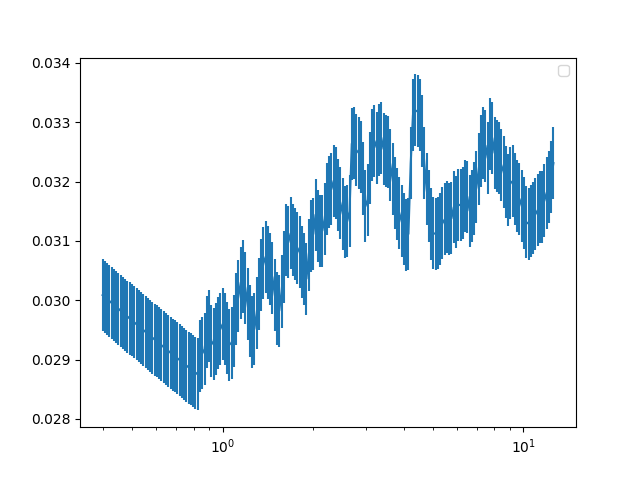

In [139]:
plt.figure()
#plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs')
plt.errorbar((10000/obs.wavelengthGrid),obs.spectrum,obs.errorBar)
plt.xscale('log')
plt.legend()
plt.show()

In [140]:
#cross-sections

from taurex.cache import OpacityCache,CIACache

OpacityCache().clear_cache()
OpacityCache().set_opacity_path("/home/silvia/Desktop/Magistrale/Esami_da_dare/Computational_astrophysics/Taurex/data/xsecs")
CIACache().set_cia_path("/home/silvia/Desktop/Magistrale/Esami_da_dare/Computational_astrophysics/Taurex/data/cia/hitran")




In [141]:
# Define the planetary parameters
planet_radius = 1.27  # Jupiter radii
planet_mass=0.46       #Jupyter masses
star_radius = 0.79    # Solar radii
T_irr = 1200.0        # Irradiation temperature (K)
T_star = 5700.0       # Stellar temperature (K)

# Create temperature profile
guillot = Guillot2010(T_irr=T_irr)

# Create a planet instance
planet = Planet(planet_radius=planet_radius, planet_mass=planet_mass)  

# Create a star instance
star = BlackbodyStar(temperature=T_star, radius=star_radius)



from taurex.temperature import Isothermal

chemistry = TaurexChemistry()
# Define and randomize gas abundances for H2O, CH4, CO2, and CO
gases = ['H2O', 'CH4', 'CO2', 'CO']
for gas_name in gases:
    abundance = 10**np.random.uniform(-8, -2)  # Randomize abundance within the specified range
    chemistry.addGas(ConstantGas(gas_name, mix_ratio=abundance))


In [142]:
isothermal = Isothermal(T=1500.0)

tm = TransmissionModel(planet=planet,
                       temperature_profile=isothermal,
                       chemistry=chemistry,
                       star=star,
                       atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)
tm.add_contribution(AbsorptionContribution())
tm.add_contribution(RayleighContribution())
tm.build()

In [143]:
tm.model()

(array([  199.99326855,   200.00660143,   200.01993521, ...,
        33328.88933329, 33331.11125925, 33333.33333333]),
 array([0.03178624, 0.03248838, 0.03145989, ..., 0.03113457, 0.03113473,
        0.03113489]),
 array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         6.29533374e-240, 5.36209237e-240, 4.56698743e-240],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.57294558e-152, 1.42065959e-152, 1.28308012e-152],
        ...,
        [9.93293523e-001, 9.32812855e-001, 9.96577194e-001, ...,
         9.96454944e-001, 9.96453913e-001, 9.96452882e-001],
        [9.96115519e-001, 9.61402671e-001, 9.98037800e-001, ...,
         9.98022382e-001, 9.98021806e-001, 9.98021230e-001],
        [9.98297928e-001, 9.83282604e-001, 9.99140101e-001, ...,
         9.99142073e-001, 9.99141823e-001, 9.99141573e-001]]),
 None)

In [149]:
from taurex.optimizer.nestle import NestleOptimizer
opt = NestleOptimizer(num_live_points=50)

opt.set_model(tm)
opt.set_observed(obs)





In [150]:
print(opt.avail_fit_parameters)


{'planet_mass': FitParam(name='planet_mass', latex='$M_p$', fget=<bound method BasePlanet.mass of <taurex.data.planet.Planet object at 0x70264d1d9420>>, fset=<bound method BasePlanet.mass of <taurex.data.planet.Planet object at 0x70264d1d9420>>, mode='linear', to_fit=False, bounds=[0.5, 1.5], prior=None), 'planet_radius': FitParam(name='planet_radius', latex='$R_p$', fget=<bound method BasePlanet.radius of <taurex.data.planet.Planet object at 0x70264d1d9420>>, fset=<bound method BasePlanet.radius of <taurex.data.planet.Planet object at 0x70264d1d9420>>, mode='linear', to_fit=False, bounds=[0.9, 1.1], prior=None), 'planet_distance': FitParam(name='planet_distance', latex='$D_{planet}$', fget=<bound method BasePlanet.distance of <taurex.data.planet.Planet object at 0x70264d1d9420>>, fset=<bound method BasePlanet.distance of <taurex.data.planet.Planet object at 0x70264d1d9420>>, mode='linear', to_fit=False, bounds=[1, 2], prior=None), 'planet_sma': FitParam(name='planet_sma', latex='$D_{p

In [151]:
opt.enable_fit('planet_radius')
opt.enable_fit('T')
opt.set_boundary('T',[1000,2000])
opt.set_boundary('planet_radius',[0.8,2.1])


In [152]:
solution = opt.fit()
taurex.log.disableLogging()

ValueError: zero-size array to reduction operation minimum which has no identity

ValueError: x and y must have same first dimension, but have shapes (576,) and (200,)

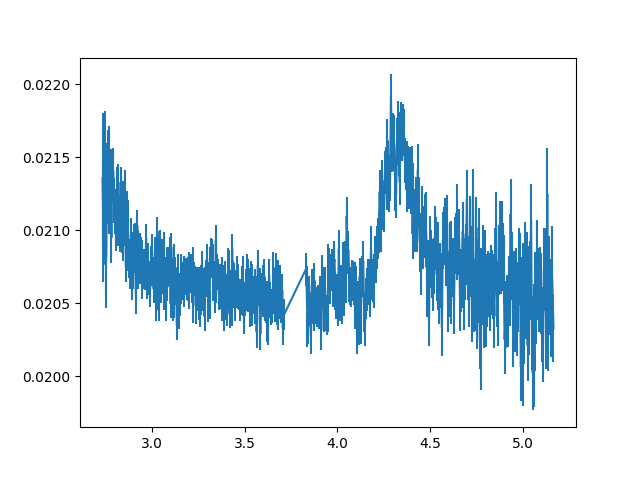

In [136]:
for solution,optimized_map,optimized_value,values in opt.get_solution():
    opt.update_model(optimized_map)
    plt.figure()
    plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs')
    plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
    plt.legend()
    plt.show()